## DINOV2

In this notebook, our team evaluates the performance of DINOv2 on our dataset, served as the baseline evaluation.

**This notebook contains the following sections:**
1. Loading Preprocessed Dataset
2. DINOv2 model architecture   
3. Hyperparameter Tuning  
4. Model Training
5. Model Evaluation

**Assumed project structure:**
```markdown
ROOT
├── notebooks
│   └── DINOv2.ipynb
└── input
    └── final_split_15Apr2025
        ├── train
        ├── eval
        └── test
```
* if dataset not downloaded, dataset would download in the loading dataset section.

References: 
- https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/
- https://docs.ray.io/en/latest/tune/examples/includes/async_hyperband_example.html
- https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html 
- https://docs.ray.io/en/latest/tune/examples/includes/mnist_pytorch.html
- https://docs.ray.io/en/latest/tune/api/suggestion.html
- https://debuggercafe.com/dinov2-for-image-classification-fine-tuning-vs-transfer-learning/
- https://github.com/facebookresearch/dinov2/tree/e1277af2ba9496fbadf7aec6eba56e8d882d1e35

Configurable Variables:
- **root (str)**: Root directory of the project (commonly set to '..').
- **data_set_directory (str)**: Name of the directory containing all datasets (i.e.,'input')
- **final_data_set (str)**: Folder name of the final processed and augmented dataset used for training.
- **root_result_folder (str)**: Top-level directory name for storing evaluation results.
- **model_directory (str)**: Directory name where all trained models will be saved.
- **model_name (str)**: Abbreviation or identifier for the model being trained (used for file naming).
- **batch_size (int)**: Number of samples per training/validation batch.

In [ ]:
# Control Panel to adjust variables
root = ".."
data_set_directory = "input"
final_data_set = "final_split_15Apr2025"
root_result_folder = "results"
model_directory = "models" 
google_drive_id = "1XhSO100qgRuLEyopfb7-4gBp0CRjZkfg"

model_name = "FINAL_DINOv2" # Name of the model that the file is training in abbreviation
batch_size = 64 # State the number of datapoints in each batch size

## Imports

Used to handle the imports

In [2]:
from typing import List, Optional, Callable
import os
import sys
from tqdm.auto import tqdm
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms

from ray import tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

# Determine the project root - required to import DataHandler from utils folder
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), root))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from utils.DataHandler import download_dataset, create_full_data_loaders, create_tuning_data_loaders

## Loading Dataset and File Location Variables

Global Variables Created:
- **PROJECT_ROOT (str)**: Absolute path to the project’s root directory; added to `sys.path` for imports.
- **LOG_DIR (str)**: Path to the directory where log files will be written.
- **MODEL_SAVE_DIR (str)**: Directory for saving model checkpoints and final trained model files.
- **CHECKPOINT_DIR (str)**: Directory where intermediate checkpoints for hyperparameter tuning are stored.
- **RESULTS_DIR (str)**: Path to store evaluation results and metrics, separated by model name.
- **BEST_MODEL_PATH (str)**: Full path to the file where the best-performing model will be saved.
- **DATASET_FOLDER (str)**: Full path to the folder containing the dataset used for training.
- **DEVICE (torch.device)**: The hardware device selected for training ('cuda', 'mps', or 'cpu').


In [ ]:
# Configuring log file
LOG_DIR = os.path.join(PROJECT_ROOT, "logs")
os.makedirs(LOG_DIR, exist_ok=True)
log_filename = os.path.join(LOG_DIR, F"{model_name}_training_log.txt")

logging.basicConfig(
    filename=log_filename,
    filemode="w",  #NOTE: previous logs would be overwritten
    format="%(asctime)s %(levelname)s: %(message)s",
    level=logging.INFO
)

# Creating the models save location
MODEL_SAVE_DIR = os.path.join(PROJECT_ROOT, model_directory, model_name)
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, F"{model_directory}/hyptune/{model_name}")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

RESULTS_DIR = os.path.join(PROJECT_ROOT, F"{root_result_folder}/{model_name}")
os.makedirs(RESULTS_DIR, exist_ok=True)

BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, F"{model_name}_best_model.pt")

DATASET_FOLDER = os.path.join(root, data_set_directory,final_data_set)

# Gets the device to be used
def get_device():
    if torch.cuda.is_available():
        print("Using device: CUDA (GPU)")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using device: MPS (Apple Silicon GPU)")
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        return torch.device("mps")
    else:
        print("Using device: CPU")
        return torch.device("cpu")

DEVICE = get_device()

Using device: CUDA (GPU)


### Download Dataset

In [ ]:
# Function to download the processed dataset used by the team
download_dataset(final_data_set,f"https://drive.google.com/uc?id={google_drive_id}",  F"{DATASET_FOLDER}.zip", "../input")

Dataset already exists at ../input/final_split_15Apr2025


### Loading Dataset

In [ ]:
SPLIT_DATASET = os.path.abspath(DATASET_FOLDER)

# Define data transformation 
# in this notebook, we are doing it for DINOv2, so we resize to ~224x224
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
print("LOADING SUBSET DATASET-----------------------------------------------------")
TRAIN_LOADER, VAL_LOADER, TEST_LOADER = create_tuning_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=batch_size,
    subset_fraction=0.5,
    random_seed=42
)
print("LOADING FULL DATASET-------------------------------------------------------")
FULL_TRAIN_LOADER, FULL_VAL_LOADER, FULL_TEST_LOADER = create_full_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=batch_size,
)

Using pre-split datasets: train 8025, val 579, test 572
Created tuning data loaders with subset fraction: 0.5
Created subset datasets for hyperparameter tuning: train 4012, val 289, test 572
Class Distribution for Subset Training:
  angry     : 983
  happy     : 1039
  relaxed   : 1024
  sad       : 966
Class Distribution for Subset Validation:
  angry     : 71
  happy     : 75
  relaxed   : 74
  sad       : 69
-------------------------------------------------------------------------
Using pre-split datasets: train 8025, val 579, test 572


## Model Specification
This part of the file will change largely based on each of the models that are being created

In [ ]:
class BaseDINOv2(nn.Module):
    """DINOv2 model for transfer learning on the dog emotion dataset
    with a configurable classification head for hyperparameter tuning, 
    i.e parameters you wish to tune need to be specified

    This model uses a pretrained DINOv2 backbone and replaces its
    classifier with a multi-layer fully connected network whose architecture
    can be tuned (number of layers, neurons, and activation function)
    """
    
    def __init__(self,
                 model_variant: str = 'dinov2_vits14',
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 freeze_backbone: bool = False,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu') -> None:
        """
        Args:
            model_variant(str): the version of DINOv2 to load.
            num_classes (int): Number of output classes.
            dropout (float): Dropout rate to apply in the classifier.
            freeze_backbone (bool): If True, freeze the backbone layers.
            hidden_sizes (Optional[List[int]]): List of sizes for hidden layers in the classifier.
                If None, a single linear layer is used.
            activation (str): Activation function to use in the classifier ('relu', 'tanh', etc.).
        """
        super(BaseDINOv2, self).__init__()

        # load DINOv2 backbone from Torch Hub
        self.backbone = torch.hub.load('facebookresearch/dinov2', model_variant)
        in_features = self.backbone.embed_dim  # e.g., 768 for vitb14, 384 for vits14
        
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Build the classifier based on the provided hidden_sizes
        layers = []
        input_dim = in_features
        if hidden_sizes:
            for hidden_dim in hidden_sizes:
                layers.append(nn.Dropout(p=dropout))
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(self._get_activation(activation))
                input_dim = hidden_dim
            # final classification layer
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        else:
            # single linear layer if no hidden layers specified
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        
        self.classifier = nn.Sequential(*layers)
    
    def _get_activation(self, activation: str) -> Callable:
        """Returns an activation function based on the given string.

        Args:
            activation (str): Name of the activation function.

        Returns:
            Callable: Activation function module.
        """
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'leakyrelu':
            return nn.LeakyReLU()
        elif activation.lower() == 'gelu':
            return nn.GELU()
        elif activation.lower() == 'tanh':
            return nn.Tanh()
        elif activation.lower() == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.backbone(x)
        return self.classifier(features)

In [7]:
print(f"Using device: {DEVICE}")
model = BaseDINOv2(model_variant="dinov2_vits14",num_classes=4, dropout=0.3, freeze_backbone=True, hidden_sizes=[256, 128], activation='relu').to(DEVICE)
print("Model instantiated:", model.__class__.__name__)
print(model)

Using device: cuda


Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Model instantiated: BaseDINOv2
BaseDINOv2(
  (backbone): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=

## Hyperparameter Tuning
This is the part where you write the training function and load it to the ray tune scheduler.
For this execution, ASHAscheduler is used with Optuna for bayesian optimisation techniques - which should be using the default Tree-Structured Parzen Estimator.
When there are multiple hyperparameters, this is would be more efficient than grid search and random search.

The hyperparameters in deep learning to tune are 
- the number of neurons
- activation function
- optimiser
- learning rate
- batch size
- epochs 
- number of layers.

In [8]:
def train_model( config, device=DEVICE, checkpoint_dir=CHECKPOINT_DIR, data_dir=None):
    """Training function for Ray Tune hyperparameter tuning.

    This function instantiates the model with hyperparameters
    specified in the config dictionary, trains the model on the global TRAIN_LOADER,
    evaluates on VAL_LOADER, and reports the validation loss to Ray Tune.

    Args:
        config (dict): Hyperparameter configuration. Expected keys include:
            - lr (float): Learning rate.
            - weight_decay (float): Weight decay for the optimizer.
            - dropout (float): Dropout rate for the classifier.
            - hidden_sizes (list or None): List of hidden layer sizes in the classifier.
            - activation (str): Activation function to use ('relu', 'tanh', etc.).
            - freeze_backbone (bool): Whether to freeze the model backbone.
            - num_epochs (int): Number of training epochs.
            - optimiser (callable, optional): Optimiser class. Default is optim.Adam.
            - criterion (callable, optional): Loss function instance. Default is nn.CrossEntropyLoss().
        checkpoint_dir (str, optional): Directory for checkpointing (if applicable).
        data_dir (str, optional): Not used here; included for compatibility.
    """
    if checkpoint_dir:
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"Checkpoint Folder exists")
    
    # instantiate model with hyperparameters from config
    model = BaseDINOv2(
        num_classes=4,
        dropout=config.get("dropout", 0.3),
        freeze_backbone=config.get("freeze_backbone", True),
        hidden_sizes=config.get("hidden_sizes", None),
        activation=config.get("activation", "relu")
    ).to(DEVICE)

    optimiser = config["optimiser"](model.parameters(), config["lr"], config["weight_decay"])
    criterion = config["criterion"]()

    num_epochs = config.get("num_epochs", 2)  # a low number for quick tuning, but update accordingly
    
    # training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0
        for inputs, targets in tqdm(TRAIN_LOADER, position=0, leave=True, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimiser.step()
            running_loss += loss.item() * inputs.size(0)
            running_correct += (outputs.argmax(1) == targets).sum().item()
            running_total   += targets.size(0) 
        
        epoch_loss = running_loss / len(TRAIN_LOADER.dataset)
        epoch_acc  = running_correct / running_total
        print(f"[TRAIN] epoch {epoch+1}: loss={epoch_loss:.4f} acc={epoch_acc:.3f}")
        
        # optionally, can checkpoint the model
        if checkpoint_dir:
            path = os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pt")
            torch.save(model.state_dict(), path)
    
    # evaluation on the subset validation set
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in VAL_LOADER:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(1) == targets).sum().item()
            val_total   += targets.size(0)
    
    avg_val_loss = val_loss / val_total
    avg_val_acc  = val_correct / val_total
    print(f"[VAL] loss={avg_val_loss:.4f} acc={avg_val_acc:.3f}")
    
    # Report the metric to Ray Tune
    tune.report({"loss": avg_val_loss, "acc": avg_val_acc})

In [ ]:
asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='loss',
    mode='min',
    max_t=100,
    grace_period=2,    
    reduction_factor=2,
    brackets=1,
)

optuna_search = OptunaSearch(metric="loss", mode="min", seed=42)

# define search space in a config dictionary, i.e what are the values you want to try
# for dinov2 gpu
config = {
    "lr": tune.loguniform(1e-4, 1e-2),    
    "weight_decay": tune.loguniform(1e-5, 1e-3),
    "dropout": tune.uniform(0.3, 0.5),
    "hidden_sizes": tune.choice([[256, 128], [512, 256], None]),
    "activation": tune.choice(["relu", "tanh", "sigmoid", "leakyrelu", "gelu"]),
    "freeze_backbone": True,
    "num_epochs": 10,
    "optimiser": tune.choice([
        lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
        lambda params, lr, wd: optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
    ]),
    "criterion": tune.choice([
        lambda: nn.CrossEntropyLoss(),
    ])
}

def trial_dirname_creator(trial):
    # this is meant to create short and unique directory name for each trial bc else too long for windows
    # include a unique identifier (like trial.trial_id).
    return f"trial_{trial.trial_id}"

def trial_name_creator(trial):
    return f"t_{trial.trial_id}"

# tuner object
tuner = tune.Tuner(
    tune.with_resources(train_model, {"cpu": 4, "gpu": 1}), #NOTE: specify based on the device u using because by default it uses all, i.e if u have 4 cpus; it does 4 concurrent trials
    tune_config=tune.TuneConfig(
        scheduler=asha_scheduler,
        search_alg=optuna_search,
        num_samples=15,  # number of trials to run
        trial_dirname_creator=trial_dirname_creator,
        trial_name_creator=trial_name_creator, 
    ),
    run_config=tune.RunConfig(
        name="basedinov2_final",
        storage_path="C:/ray_results/dinov2_final", #NOTE: not required for mac
        log_to_file=True,
        verbose=1,
        ),
    param_space=config,
)

results = tuner.fit()
print("Best config:", results.get_best_result(metric="loss", mode="min",filter_nan_and_inf=False).config)

best_config = results.get_best_result(metric="loss", mode="min").config
print("Full best config:", best_config)

(train_model pid=31008) Checkpoint Folder exists


(train_model pid=31008) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=31008) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=31008)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=31008) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=31008)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=31008) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=31008)   warnings.warn("xFormers is not available (Block)")
Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=31008) [TRAIN] epoch 1: loss=1.1389 acc=0.507


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=31008) [TRAIN] epoch 2: loss=0.8559 acc=0.654


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=31008) [TRAIN] epoch 3: loss=0.7923 acc=0.679


Epoch 5/10:   2%|▏         | 1/63 [00:00<00:07,  8.57it/s]


(train_model pid=31008) [TRAIN] epoch 4: loss=0.7709 acc=0.694


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=31008) [TRAIN] epoch 5: loss=0.7371 acc=0.711


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=31008) [TRAIN] epoch 6: loss=0.7373 acc=0.700


Epoch 7/10: 100%|██████████| 63/63 [00:07<00:00,  8.52it/s]


(train_model pid=31008) [TRAIN] epoch 7: loss=0.7293 acc=0.703


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=31008) [TRAIN] epoch 8: loss=0.7094 acc=0.709


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=31008) [TRAIN] epoch 9: loss=0.7084 acc=0.724


Epoch 10/10: 100%|██████████| 63/63 [00:07<00:00,  8.53it/s]


(train_model pid=31008) [TRAIN] epoch 10: loss=0.6978 acc=0.717


2025-04-20 18:09:30,158	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=31008) [VAL] loss=0.5418 acc=0.779
(train_model pid=20120) Checkpoint Folder exists


(train_model pid=20120) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=20120) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=20120)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=20120) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=20120)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=20120) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=20120)   warnings.warn("xFormers is not available (Block)")
Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20120) [TRAIN] epoch 1: loss=1.3824 acc=0.307


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20120) [TRAIN] epoch 2: loss=1.3114 acc=0.396


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20120) [TRAIN] epoch 3: loss=1.2421 acc=0.461


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20120) [TRAIN] epoch 4: loss=1.1922 acc=0.500


Epoch 5/10: 100%|██████████| 63/63 [00:07<00:00,  8.60it/s]


(train_model pid=20120) [TRAIN] epoch 5: loss=1.1497 acc=0.532


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20120) [TRAIN] epoch 6: loss=1.1143 acc=0.547


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20120) [TRAIN] epoch 7: loss=1.0756 acc=0.569


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20120) [TRAIN] epoch 8: loss=1.0447 acc=0.586


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20120) [TRAIN] epoch 9: loss=1.0091 acc=0.599


Epoch 10/10: 100%|██████████| 63/63 [00:07<00:00,  8.57it/s]


(train_model pid=20120) [TRAIN] epoch 10: loss=0.9947 acc=0.604


2025-04-20 18:10:50,798	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=20120) [VAL] loss=0.9472 acc=0.595
(train_model pid=26532) Checkpoint Folder exists


(train_model pid=26532) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=26532) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=26532)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=26532) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=26532)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=26532) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=26532)   warnings.warn("xFormers is not available (Block)")
Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26532) [TRAIN] epoch 1: loss=1.4145 acc=0.263


Epoch 2/10: 100%|██████████| 63/63 [00:07<00:00,  8.58it/s]


(train_model pid=26532) [TRAIN] epoch 2: loss=1.4057 acc=0.264


Epoch 3/10: 100%|██████████| 63/63 [00:07<00:00,  8.49it/s]


(train_model pid=26532) [TRAIN] epoch 3: loss=1.4061 acc=0.249


Epoch 4/10: 100%|██████████| 63/63 [00:07<00:00,  8.52it/s]


(train_model pid=26532) [TRAIN] epoch 4: loss=1.4065 acc=0.250


Epoch 5/10: 100%|██████████| 63/63 [00:07<00:00,  8.52it/s]


(train_model pid=26532) [TRAIN] epoch 5: loss=1.4033 acc=0.258


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26532) [TRAIN] epoch 6: loss=1.3958 acc=0.258


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26532) [TRAIN] epoch 7: loss=1.4043 acc=0.257


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26532) [TRAIN] epoch 8: loss=1.3986 acc=0.258


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26532) [TRAIN] epoch 9: loss=1.3994 acc=0.264


Epoch 10/10: 100%|██████████| 63/63 [00:07<00:00,  8.49it/s]


(train_model pid=26532) [TRAIN] epoch 10: loss=1.3944 acc=0.271


2025-04-20 18:12:12,330	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=26532) [VAL] loss=1.3773 acc=0.263
(train_model pid=33020) Checkpoint Folder exists


(train_model pid=33020) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=33020) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=33020)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=33020) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=33020)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=33020) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=33020)   warnings.warn("xFormers is not available (Block)")
Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=33020) [TRAIN] epoch 1: loss=1.0436 acc=0.541


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=33020) [TRAIN] epoch 2: loss=0.7866 acc=0.683


Epoch 4/10:   2%|▏         | 1/63 [00:00<00:07,  8.70it/s]


(train_model pid=33020) [TRAIN] epoch 3: loss=0.6975 acc=0.719


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=33020) [TRAIN] epoch 4: loss=0.6475 acc=0.740


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=33020) [TRAIN] epoch 5: loss=0.6067 acc=0.760


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=33020) [TRAIN] epoch 6: loss=0.5608 acc=0.779


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=33020) [TRAIN] epoch 7: loss=0.5355 acc=0.791


Epoch 8/10:  97%|█████████▋| 61/63 [00:07<00:00,  8.46it/s]


(train_model pid=33020) [TRAIN] epoch 8: loss=0.4910 acc=0.814


Epoch 10/10:   2%|▏         | 1/63 [00:00<00:07,  8.06it/s]


(train_model pid=33020) [TRAIN] epoch 9: loss=0.4788 acc=0.817


Epoch 10/10: 100%|██████████| 63/63 [00:07<00:00,  8.53it/s]


(train_model pid=33020) [TRAIN] epoch 10: loss=0.4416 acc=0.832


2025-04-20 18:13:32,833	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=33020) [VAL] loss=0.5119 acc=0.817
(train_model pid=27564) Checkpoint Folder exists


(train_model pid=27564) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=27564) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=27564)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=27564) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=27564)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=27564) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=27564)   warnings.warn("xFormers is not available (Block)")
Epoch 2/10:   2%|▏         | 1/63 [00:00<00:07,  8.52it/s]


(train_model pid=27564) [TRAIN] epoch 1: loss=1.0886 acc=0.544


Epoch 3/10:   2%|▏         | 1/63 [00:00<00:07,  7.90it/s]


(train_model pid=27564) [TRAIN] epoch 2: loss=0.9154 acc=0.644


Epoch 4/10:   2%|▏         | 1/63 [00:00<00:07,  8.55it/s]


(train_model pid=27564) [TRAIN] epoch 3: loss=0.9065 acc=0.647


Epoch 5/10:   2%|▏         | 1/63 [00:00<00:07,  8.58it/s]


(train_model pid=27564) [TRAIN] epoch 4: loss=0.9127 acc=0.643


Epoch 6/10:   2%|▏         | 1/63 [00:00<00:07,  8.48it/s]


(train_model pid=27564) [TRAIN] epoch 5: loss=0.8842 acc=0.658


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27564) [TRAIN] epoch 6: loss=0.8657 acc=0.674


Epoch 8/10:   2%|▏         | 1/63 [00:00<00:07,  8.34it/s]


(train_model pid=27564) [TRAIN] epoch 7: loss=0.8687 acc=0.662


Epoch 8/10: 100%|██████████| 63/63 [00:07<00:00,  8.52it/s]


(train_model pid=27564) [TRAIN] epoch 8: loss=0.8427 acc=0.674


Epoch 10/10:   2%|▏         | 1/63 [00:00<00:07,  8.33it/s]


(train_model pid=27564) [TRAIN] epoch 9: loss=0.8662 acc=0.659


Epoch 10/10: 100%|██████████| 63/63 [00:07<00:00,  8.51it/s]


(train_model pid=27564) [TRAIN] epoch 10: loss=0.8673 acc=0.661


2025-04-20 18:14:53,147	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=27564) [VAL] loss=0.7056 acc=0.734
(train_model pid=39512) Checkpoint Folder exists


(train_model pid=39512) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=39512) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=39512)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=39512) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=39512)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=39512) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=39512)   warnings.warn("xFormers is not available (Block)")
Epoch 2/10:   2%|▏         | 1/63 [00:00<00:07,  8.72it/s]


(train_model pid=39512) [TRAIN] epoch 1: loss=1.1403 acc=0.488


Epoch 2/10:  95%|█████████▌| 60/63 [00:07<00:00,  8.66it/s]


(train_model pid=39512) [TRAIN] epoch 2: loss=0.8162 acc=0.676


Epoch 4/10:   2%|▏         | 1/63 [00:00<00:07,  8.41it/s]


(train_model pid=39512) [TRAIN] epoch 3: loss=0.7626 acc=0.698


Epoch 5/10:   2%|▏         | 1/63 [00:00<00:07,  8.31it/s]


(train_model pid=39512) [TRAIN] epoch 4: loss=0.7404 acc=0.709


Epoch 6/10:   2%|▏         | 1/63 [00:00<00:07,  8.30it/s]


(train_model pid=39512) [TRAIN] epoch 5: loss=0.7270 acc=0.710


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=39512) [TRAIN] epoch 6: loss=0.6951 acc=0.727


Epoch 8/10:   2%|▏         | 1/63 [00:00<00:07,  8.32it/s]


(train_model pid=39512) [TRAIN] epoch 7: loss=0.6824 acc=0.734


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=39512) [TRAIN] epoch 8: loss=0.6452 acc=0.743


Epoch 10/10:   2%|▏         | 1/63 [00:00<00:07,  8.46it/s]


(train_model pid=39512) [TRAIN] epoch 9: loss=0.6290 acc=0.751


Epoch 10/10: 100%|██████████| 63/63 [00:07<00:00,  8.62it/s]


(train_model pid=39512) [TRAIN] epoch 10: loss=0.6227 acc=0.748


2025-04-20 18:16:14,270	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=39512) [VAL] loss=0.5543 acc=0.779
(train_model pid=37332) Checkpoint Folder exists


(train_model pid=37332) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=37332) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=37332)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=37332) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=37332)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=37332) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=37332)   warnings.warn("xFormers is not available (Block)")
Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=37332) [TRAIN] epoch 1: loss=1.2395 acc=0.422


Epoch 3/10:   2%|▏         | 1/63 [00:00<00:07,  8.74it/s]


(train_model pid=37332) [TRAIN] epoch 2: loss=0.9816 acc=0.593


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=37332) [TRAIN] epoch 3: loss=0.8656 acc=0.641


Epoch 4/10: 100%|██████████| 63/63 [00:07<00:00,  8.52it/s]


(train_model pid=37332) [TRAIN] epoch 4: loss=0.8179 acc=0.671


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=37332) [TRAIN] epoch 5: loss=0.7762 acc=0.679


Epoch 6/10: 100%|██████████| 63/63 [00:07<00:00,  8.49it/s]


(train_model pid=37332) [TRAIN] epoch 6: loss=0.7325 acc=0.710


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=37332) [TRAIN] epoch 7: loss=0.7216 acc=0.721


Epoch 8/10: 100%|██████████| 63/63 [00:07<00:00,  8.51it/s]


(train_model pid=37332) [TRAIN] epoch 8: loss=0.6887 acc=0.720


Epoch 10/10:   2%|▏         | 1/63 [00:00<00:07,  8.58it/s]


(train_model pid=37332) [TRAIN] epoch 9: loss=0.6847 acc=0.727


Epoch 10/10: 100%|██████████| 63/63 [00:07<00:00,  8.45it/s]


(train_model pid=37332) [TRAIN] epoch 10: loss=0.6826 acc=0.739


2025-04-20 18:17:35,588	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=37332) [VAL] loss=0.5977 acc=0.792
(train_model pid=4892) Checkpoint Folder exists


(train_model pid=4892) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=4892) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=4892)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=4892) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=4892)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=4892) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=4892)   warnings.warn("xFormers is not available (Block)")
Epoch 2/10:   2%|▏         | 1/63 [00:00<00:07,  8.59it/s]


(train_model pid=4892) [TRAIN] epoch 1: loss=1.3451 acc=0.349


Epoch 3/10:   2%|▏         | 1/63 [00:00<00:07,  8.51it/s]


(train_model pid=4892) [TRAIN] epoch 2: loss=1.1218 acc=0.515


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=4892) [TRAIN] epoch 3: loss=0.9700 acc=0.596


Epoch 5/10:   2%|▏         | 1/63 [00:00<00:07,  8.30it/s]


(train_model pid=4892) [TRAIN] epoch 4: loss=0.8947 acc=0.631


Epoch 6/10:   2%|▏         | 1/63 [00:00<00:07,  8.18it/s]


(train_model pid=4892) [TRAIN] epoch 5: loss=0.8408 acc=0.659


Epoch 6/10: 100%|██████████| 63/63 [00:07<00:00,  8.63it/s]


(train_model pid=4892) [TRAIN] epoch 6: loss=0.7867 acc=0.680


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=4892) [TRAIN] epoch 7: loss=0.7644 acc=0.700


Epoch 9/10:   2%|▏         | 1/63 [00:00<00:06,  8.87it/s]


(train_model pid=4892) [TRAIN] epoch 8: loss=0.7502 acc=0.700


Epoch 10/10:   2%|▏         | 1/63 [00:00<00:07,  8.48it/s]


(train_model pid=4892) [TRAIN] epoch 9: loss=0.6941 acc=0.723


Epoch 10/10: 100%|██████████| 63/63 [00:07<00:00,  8.64it/s]


(train_model pid=4892) [TRAIN] epoch 10: loss=0.6922 acc=0.726


2025-04-20 18:18:54,696	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=4892) [VAL] loss=0.5997 acc=0.761
(train_model pid=29880) Checkpoint Folder exists


(train_model pid=29880) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=29880) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=29880)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=29880) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=29880)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=29880) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=29880)   warnings.warn("xFormers is not available (Block)")
Epoch 1/10: 100%|██████████| 63/63 [00:07<00:00,  8.44it/s]


(train_model pid=29880) [TRAIN] epoch 1: loss=0.9738 acc=0.593


Epoch 2/10:  98%|█████████▊| 62/63 [00:07<00:00,  8.45it/s]


(train_model pid=29880) [TRAIN] epoch 2: loss=0.7404 acc=0.705


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29880) [TRAIN] epoch 3: loss=0.7024 acc=0.718


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29880) [TRAIN] epoch 4: loss=0.6577 acc=0.740


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29880) [TRAIN] epoch 5: loss=0.6424 acc=0.748


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29880) [TRAIN] epoch 6: loss=0.6077 acc=0.752


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29880) [TRAIN] epoch 7: loss=0.6283 acc=0.758


Epoch 8/10: 100%|██████████| 63/63 [00:07<00:00,  8.60it/s]


(train_model pid=29880) [TRAIN] epoch 8: loss=0.5972 acc=0.763


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29880) [TRAIN] epoch 9: loss=0.5867 acc=0.772


Epoch 10/10: 100%|██████████| 63/63 [00:07<00:00,  8.57it/s]


(train_model pid=29880) [TRAIN] epoch 10: loss=0.5816 acc=0.764


2025-04-20 18:20:14,879	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=29880) [VAL] loss=0.5906 acc=0.751
(train_model pid=24468) Checkpoint Folder exists


(train_model pid=24468) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=24468) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=24468)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=24468) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=24468)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=24468) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=24468)   warnings.warn("xFormers is not available (Block)")
Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24468) [TRAIN] epoch 1: loss=1.4519 acc=0.251


Epoch 3/10:   2%|▏         | 1/63 [00:00<00:07,  8.65it/s]


(train_model pid=24468) [TRAIN] epoch 2: loss=1.3905 acc=0.306


Epoch 4/10:   2%|▏         | 1/63 [00:00<00:07,  8.75it/s]


(train_model pid=24468) [TRAIN] epoch 3: loss=1.3453 acc=0.343


Epoch 5/10:   2%|▏         | 1/63 [00:00<00:07,  8.71it/s]


(train_model pid=24468) [TRAIN] epoch 4: loss=1.3103 acc=0.395


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24468) [TRAIN] epoch 5: loss=1.2756 acc=0.403


Epoch 7/10:   2%|▏         | 1/63 [00:00<00:06,  8.89it/s]


(train_model pid=24468) [TRAIN] epoch 6: loss=1.2374 acc=0.444


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24468) [TRAIN] epoch 7: loss=1.2049 acc=0.471


Epoch 9/10:   2%|▏         | 1/63 [00:00<00:07,  8.76it/s]


(train_model pid=24468) [TRAIN] epoch 8: loss=1.1797 acc=0.489


Epoch 10/10:   2%|▏         | 1/63 [00:00<00:07,  8.62it/s]


(train_model pid=24468) [TRAIN] epoch 9: loss=1.1563 acc=0.499


Epoch 10/10: 100%|██████████| 63/63 [00:07<00:00,  8.68it/s]


(train_model pid=24468) [TRAIN] epoch 10: loss=1.1272 acc=0.517


2025-04-20 18:21:33,624	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=24468) [VAL] loss=1.0679 acc=0.571
(train_model pid=31288) Checkpoint Folder exists


(train_model pid=31288) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=31288) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=31288)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=31288) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=31288)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=31288) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=31288)   warnings.warn("xFormers is not available (Block)")
Epoch 1/10: 100%|██████████| 63/63 [00:07<00:00,  8.41it/s]


(train_model pid=31288) [TRAIN] epoch 1: loss=1.3788 acc=0.304


Epoch 3/10:   2%|▏         | 1/63 [00:00<00:07,  8.53it/s]


(train_model pid=31288) [TRAIN] epoch 2: loss=1.2449 acc=0.442


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=31288) [TRAIN] epoch 3: loss=1.1432 acc=0.515


Epoch 5/10:   2%|▏         | 1/63 [00:00<00:07,  8.56it/s]


(train_model pid=31288) [TRAIN] epoch 4: loss=1.0572 acc=0.547


Epoch 6/10:   2%|▏         | 1/63 [00:00<00:07,  8.38it/s]


(train_model pid=31288) [TRAIN] epoch 5: loss=0.9705 acc=0.605


Epoch 7/10:   2%|▏         | 1/63 [00:00<00:07,  8.51it/s]


(train_model pid=31288) [TRAIN] epoch 6: loss=0.9350 acc=0.612


Epoch 7/10:  98%|█████████▊| 62/63 [00:07<00:00,  8.47it/s]


(train_model pid=31288) [TRAIN] epoch 7: loss=0.8816 acc=0.645


Epoch 9/10:   2%|▏         | 1/63 [00:00<00:07,  8.65it/s]


(train_model pid=31288) [TRAIN] epoch 8: loss=0.8367 acc=0.660


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=31288) [TRAIN] epoch 9: loss=0.8110 acc=0.664


Epoch 10/10: 100%|██████████| 63/63 [00:07<00:00,  8.59it/s]


(train_model pid=31288) [TRAIN] epoch 10: loss=0.7869 acc=0.677


2025-04-20 18:22:53,896	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=31288) [VAL] loss=0.6965 acc=0.696
(train_model pid=39304) Checkpoint Folder exists


(train_model pid=39304) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=39304) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=39304)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=39304) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=39304)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=39304) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=39304)   warnings.warn("xFormers is not available (Block)")
Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=39304) [TRAIN] epoch 1: loss=1.1770 acc=0.548


Epoch 3/10:   2%|▏         | 1/63 [00:00<00:07,  8.58it/s]


(train_model pid=39304) [TRAIN] epoch 2: loss=0.7636 acc=0.695


Epoch 3/10: 100%|██████████| 63/63 [00:07<00:00,  8.54it/s]


(train_model pid=39304) [TRAIN] epoch 3: loss=0.6969 acc=0.723


Epoch 5/10:   2%|▏         | 1/63 [00:00<00:07,  8.48it/s]


(train_model pid=39304) [TRAIN] epoch 4: loss=0.6666 acc=0.732


Epoch 5/10: 100%|██████████| 63/63 [00:07<00:00,  8.57it/s]


(train_model pid=39304) [TRAIN] epoch 5: loss=0.6498 acc=0.739


Epoch 7/10:   2%|▏         | 1/63 [00:00<00:07,  8.32it/s]


(train_model pid=39304) [TRAIN] epoch 6: loss=0.6237 acc=0.755


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=39304) [TRAIN] epoch 7: loss=0.6237 acc=0.752


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=39304) [TRAIN] epoch 8: loss=0.6433 acc=0.745


Epoch 10/10:   2%|▏         | 1/63 [00:00<00:07,  8.59it/s]


(train_model pid=39304) [TRAIN] epoch 9: loss=0.6498 acc=0.746


Epoch 10/10: 100%|██████████| 63/63 [00:07<00:00,  8.54it/s]


(train_model pid=39304) [TRAIN] epoch 10: loss=0.6114 acc=0.754


2025-04-20 18:24:14,313	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=39304) [VAL] loss=0.5215 acc=0.796
(train_model pid=19640) Checkpoint Folder exists


(train_model pid=19640) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=19640) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=19640)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=19640) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=19640)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=19640) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=19640)   warnings.warn("xFormers is not available (Block)")
Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=19640) [TRAIN] epoch 1: loss=1.9913 acc=0.301


Epoch 3/10:   2%|▏         | 1/63 [00:00<00:07,  8.71it/s]


(train_model pid=19640) [TRAIN] epoch 2: loss=1.6629 acc=0.364


Epoch 4/10:   2%|▏         | 1/63 [00:00<00:07,  8.44it/s]


(train_model pid=19640) [TRAIN] epoch 3: loss=1.4515 acc=0.429


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=19640) [TRAIN] epoch 4: loss=1.3279 acc=0.467


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=19640) [TRAIN] epoch 5: loss=1.2448 acc=0.504


Epoch 7/10:   2%|▏         | 1/63 [00:00<00:07,  8.61it/s]


(train_model pid=19640) [TRAIN] epoch 6: loss=1.1449 acc=0.534


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=19640) [TRAIN] epoch 7: loss=1.0737 acc=0.558


Epoch 9/10:   2%|▏         | 1/63 [00:00<00:07,  8.41it/s]


(train_model pid=19640) [TRAIN] epoch 8: loss=1.0402 acc=0.577


Epoch 10/10:   2%|▏         | 1/63 [00:00<00:07,  8.57it/s]


(train_model pid=19640) [TRAIN] epoch 9: loss=0.9778 acc=0.610


Epoch 10/10: 100%|██████████| 63/63 [00:07<00:00,  8.50it/s]


(train_model pid=19640) [TRAIN] epoch 10: loss=0.9702 acc=0.615


2025-04-20 18:25:35,709	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=19640) [VAL] loss=0.8230 acc=0.664
(train_model pid=30020) Checkpoint Folder exists


(train_model pid=30020) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=30020) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=30020)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=30020) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=30020)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=30020) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=30020)   warnings.warn("xFormers is not available (Block)")
Epoch 2/10:   2%|▏         | 1/63 [00:00<00:07,  8.77it/s]


(train_model pid=30020) [TRAIN] epoch 1: loss=1.1332 acc=0.557


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30020) [TRAIN] epoch 2: loss=0.7872 acc=0.690


Epoch 4/10:   2%|▏         | 1/63 [00:00<00:07,  8.85it/s]


(train_model pid=30020) [TRAIN] epoch 3: loss=0.7215 acc=0.712


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30020) [TRAIN] epoch 4: loss=0.7178 acc=0.719


Epoch 6/10:   2%|▏         | 1/63 [00:00<00:06,  8.86it/s]


(train_model pid=30020) [TRAIN] epoch 5: loss=0.6961 acc=0.722


Epoch 7/10:   2%|▏         | 1/63 [00:00<00:07,  8.67it/s]


(train_model pid=30020) [TRAIN] epoch 6: loss=0.7050 acc=0.723


Epoch 8/10:   2%|▏         | 1/63 [00:00<00:07,  8.30it/s]


(train_model pid=30020) [TRAIN] epoch 7: loss=0.6998 acc=0.720


Epoch 8/10: 100%|██████████| 63/63 [00:07<00:00,  8.61it/s]


(train_model pid=30020) [TRAIN] epoch 8: loss=0.7034 acc=0.723


Epoch 10/10:   2%|▏         | 1/63 [00:00<00:07,  8.49it/s]


(train_model pid=30020) [TRAIN] epoch 9: loss=0.7121 acc=0.720


Epoch 10/10: 100%|██████████| 63/63 [00:07<00:00,  8.60it/s]


(train_model pid=30020) [TRAIN] epoch 10: loss=0.7230 acc=0.716


2025-04-20 18:26:55,432	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=30020) [VAL] loss=0.5872 acc=0.775
(train_model pid=37732) Checkpoint Folder exists


(train_model pid=37732) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=37732) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=37732)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=37732) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=37732)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=37732) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=37732)   warnings.warn("xFormers is not available (Block)")
Epoch 2/10:   2%|▏         | 1/63 [00:00<00:07,  8.43it/s]


(train_model pid=37732) [TRAIN] epoch 1: loss=1.2251 acc=0.538


Epoch 3/10:   2%|▏         | 1/63 [00:00<00:07,  8.57it/s]


(train_model pid=37732) [TRAIN] epoch 2: loss=0.7922 acc=0.691


Epoch 4/10:   2%|▏         | 1/63 [00:00<00:07,  8.62it/s]


(train_model pid=37732) [TRAIN] epoch 3: loss=0.7165 acc=0.715


Epoch 5/10:   2%|▏         | 1/63 [00:00<00:07,  8.74it/s]


(train_model pid=37732) [TRAIN] epoch 4: loss=0.6955 acc=0.723


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=37732) [TRAIN] epoch 5: loss=0.6806 acc=0.723


Epoch 7/10:   2%|▏         | 1/63 [00:00<00:07,  8.51it/s]


(train_model pid=37732) [TRAIN] epoch 6: loss=0.6809 acc=0.730


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=37732) [TRAIN] epoch 7: loss=0.6742 acc=0.739


Epoch 9/10:   2%|▏         | 1/63 [00:00<00:07,  8.71it/s]


(train_model pid=37732) [TRAIN] epoch 8: loss=0.7183 acc=0.711


Epoch 10/10:   2%|▏         | 1/63 [00:00<00:06,  9.01it/s]


(train_model pid=37732) [TRAIN] epoch 9: loss=0.6924 acc=0.721


Epoch 10/10: 100%|██████████| 63/63 [00:07<00:00,  8.54it/s]


(train_model pid=37732) [TRAIN] epoch 10: loss=0.6926 acc=0.729


2025-04-20 18:28:14,660	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2'), 'criterion': ('__ref_ph', 'f6251774')}
2025-04-20 18:28:14,684	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/ray_results/dinov2_final_FINAL/basedinov2_final_FINAL' in 0.0212s.


(train_model pid=37732) [VAL] loss=0.5559 acc=0.806


2025-04-20 18:28:14,704	INFO tune.py:1041 -- Total run time: 1206.86 seconds (1206.76 seconds for the tuning loop).


Best config: {'lr': 0.0007591104805282694, 'weight_decay': 1.7541893487450798e-05, 'dropout': 0.399035382022254, 'hidden_sizes': [512, 256], 'activation': 'relu', 'freeze_backbone': True, 'num_epochs': 10, 'optimiser': <function <lambda> at 0x0000012059E8C040>, 'criterion': <function <lambda> at 0x0000012059E8C700>}
Full best config: {'lr': 0.0007591104805282694, 'weight_decay': 1.7541893487450798e-05, 'dropout': 0.399035382022254, 'hidden_sizes': [512, 256], 'activation': 'relu', 'freeze_backbone': True, 'num_epochs': 10, 'optimiser': <function <lambda> at 0x0000012059E8C040>, 'criterion': <function <lambda> at 0x0000012059E8C700>}


## Final Model Training

In [ ]:
#### Good configs, saved after various experimentations
# This cell can be skipped if hyper parameter tuning was run
# best_config = {
#     'lr': 0.0007591104805282694,
#     'weight_decay': 1.7541893487450798e-05,
#     'dropout': 0.399035382022254,
#     'hidden_sizes': [512, 256],
#     'activation': 'relu',
#     'freeze_backbone': True,
#     'num_epochs': 10,
#     'optimiser': lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
#     'criterion': lambda: nn.CrossEntropyLoss()
# }

In [11]:
final_model = BaseDINOv2(
    num_classes=4,
    dropout=best_config["dropout"],
    freeze_backbone=best_config["freeze_backbone"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"]
)

optimiser = best_config["optimiser"](final_model.parameters(), lr=best_config["lr"], wd=best_config["weight_decay"])
criterion = best_config["criterion"]()

print(optimiser)
print(criterion)

final_model = final_model.to(DEVICE)
logging.info("Model instantiated on device: %s", DEVICE)

Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0007591104805282694
    maximize: False
    weight_decay: 1.7541893487450798e-05
)
CrossEntropyLoss()


In [ ]:
# early stopping parameters
patience = 5  # the number of epochs to wait to see if got improvements
best_val_loss = float('inf')
epochs_without_improvement = 0

num_epochs_full = 50

train_losses = []
val_losses = []
train_accs   = [] 
val_accs     = [] 

# training loop with early stopping
for epoch in range(num_epochs_full):
    final_model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0
    for inputs, targets in tqdm(FULL_TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs_full}"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimiser.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimiser.step()
        _, predicted = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_correct+= (predicted == targets).sum().item()
        running_total  += targets.size(0)
    epoch_train_loss = running_loss / running_total
    epoch_train_acc  = running_correct / running_total
    train_accs.append(epoch_train_acc)
    train_losses.append(epoch_train_loss)
    logging.info("Epoch %d: Training Loss: %.4f", epoch+1, epoch_train_loss)
    
    # evaluate on the validation set
    final_model.eval()
    running_val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in FULL_VAL_LOADER:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = final_model(inputs)
            loss = criterion(outputs, targets)
            _, predicted = torch.max(outputs, 1)
            running_val_loss += loss.item() * inputs.size(0)
            val_correct     += (predicted == targets).sum().item()
            val_total       += targets.size(0)
    epoch_val_loss = running_val_loss / val_total
    epoch_val_acc  = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    logging.info("Epoch %d: Validation Loss: %.4f", epoch+1, epoch_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs_full} - Train Loss: {epoch_train_loss:.4f}, Train Acc={epoch_train_acc:.3f} | Val Loss: {epoch_val_loss:.4f}, Val Acc={epoch_val_acc:.3f}")
    
    # if no improvement then early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        # save the best model
        torch.save(final_model.state_dict(), BEST_MODEL_PATH)
        logging.info("Model saved to: %s",  {BEST_MODEL_PATH})
        logging.info("Epoch %d: New best model saved.", epoch+1)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        logging.info("Early stopping triggered at epoch %d", epoch+1)
        break

Epoch 1/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 1/50 - Train Loss: 0.9510, Train Acc=0.596 | Val Loss: 0.6196, Val Acc=0.765


Epoch 2/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 2/50 - Train Loss: 0.7152, Train Acc=0.712 | Val Loss: 0.5676, Val Acc=0.781


Epoch 3/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 3/50 - Train Loss: 0.6220, Train Acc=0.751 | Val Loss: 0.5101, Val Acc=0.820


Epoch 4/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 4/50 - Train Loss: 0.5692, Train Acc=0.772 | Val Loss: 0.4943, Val Acc=0.815


Epoch 5/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 5/50 - Train Loss: 0.5365, Train Acc=0.792 | Val Loss: 0.4918, Val Acc=0.807


Epoch 6/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 6/50 - Train Loss: 0.4928, Train Acc=0.807 | Val Loss: 0.4988, Val Acc=0.798


Epoch 7/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 7/50 - Train Loss: 0.4510, Train Acc=0.824 | Val Loss: 0.4816, Val Acc=0.793


Epoch 8/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 8/50 - Train Loss: 0.4193, Train Acc=0.837 | Val Loss: 0.4585, Val Acc=0.822


Epoch 9/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 9/50 - Train Loss: 0.3958, Train Acc=0.855 | Val Loss: 0.4509, Val Acc=0.813


Epoch 10/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 10/50 - Train Loss: 0.3678, Train Acc=0.859 | Val Loss: 0.5009, Val Acc=0.808


Epoch 11/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 11/50 - Train Loss: 0.3476, Train Acc=0.866 | Val Loss: 0.4924, Val Acc=0.807


Epoch 12/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 12/50 - Train Loss: 0.3354, Train Acc=0.878 | Val Loss: 0.5187, Val Acc=0.817


Epoch 13/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 13/50 - Train Loss: 0.3125, Train Acc=0.882 | Val Loss: 0.5213, Val Acc=0.808


Epoch 14/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 14/50 - Train Loss: 0.3091, Train Acc=0.882 | Val Loss: 0.4984, Val Acc=0.808
Early stopping triggered.


## Testing

Test Loss: 0.5304, Test Accuracy: 80.24%


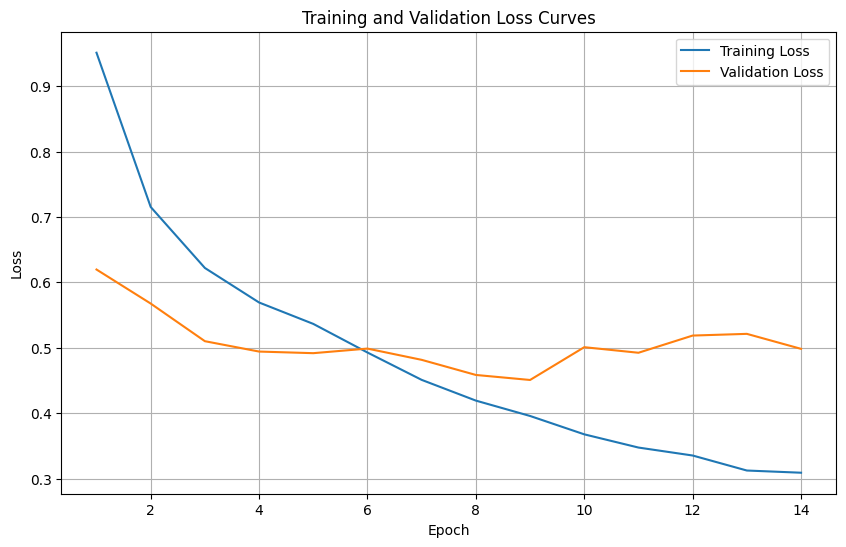

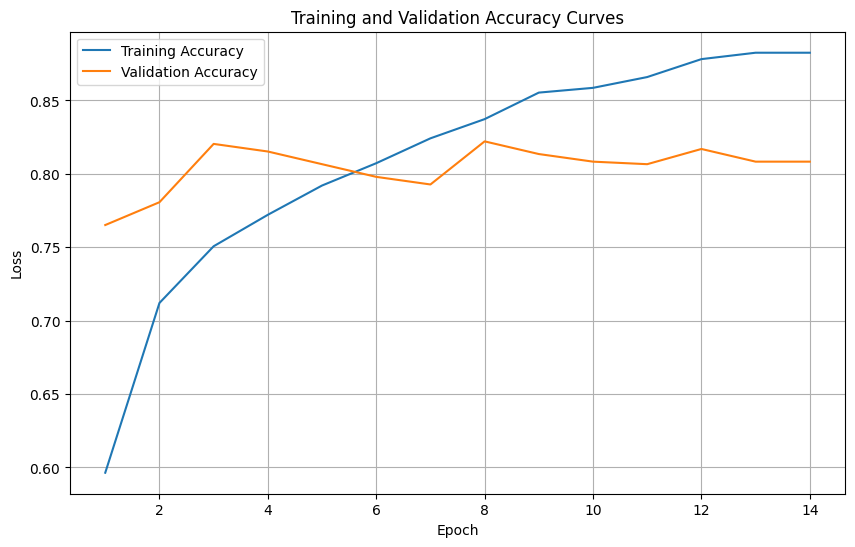


Classification Report:
               precision    recall  f1-score   support

       angry       0.80      0.79      0.80       140
       happy       0.80      0.82      0.81       148
     relaxed       0.79      0.75      0.77       146
         sad       0.82      0.85      0.83       138

    accuracy                           0.80       572
   macro avg       0.80      0.80      0.80       572
weighted avg       0.80      0.80      0.80       572


 F1 score: 0.8024741705820053; 
 Precision score: 0.8023921083235797; 
 Recall Score: 0.8029188637288696


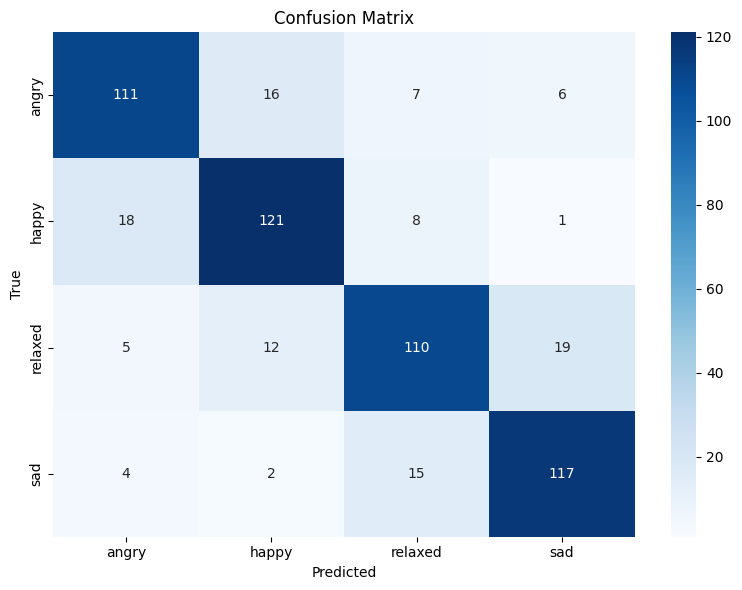

In [ ]:
# load best model from training
final_model.load_state_dict(torch.load(BEST_MODEL_PATH))
final_model.to(DEVICE)
final_model.eval()

# initialise metrics
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in FULL_TEST_LOADER:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = final_model(images)
        # for test loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        # for accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy()) # move to cpu to ensure compatibility because numpy only operates on cpu
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(FULL_TEST_LOADER.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

# plotting training and validation loss curves
if 'train_losses' in globals() and 'val_losses' in globals():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    loss_curve_path = os.path.join(RESULTS_DIR, "loss_curves.png") #NOTE: specify by model name
    plt.savefig(loss_curve_path)
    plt.show()
    logging.info("Training and Validation Loss curves saved to %s", loss_curve_path)
else:
    logging.warning("train_losses and val_losses are not defined. Skipping loss curves plot.")

# plotting training and validation acc curves
if 'train_accs' in globals() and 'val_accs' in globals():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_accs)+1), train_accs, label="Training Accuracy")
    plt.plot(range(1, len(val_accs)+1), val_accs, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Accuracy Curves")
    plt.legend()
    plt.grid(True)
    acc_curve_path = os.path.join(RESULTS_DIR, "accuracy_curves.png")
    plt.savefig(acc_curve_path)
    plt.show()
    logging.info("Training and Validation Accuracy curves saved to %s", acc_curve_path)
else:
    logging.warning("train_accs and val_accs are not defined. Skipping accuracy curves plot.")

# generate and log classification report
class_names = FULL_TEST_LOADER.dataset.classes
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n", report)
logging.info("Classification Report:\n%s", report)

# print f1, precision, recall scores
f1 = f1_score(all_labels, all_preds, average='macro')
prec = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')
print(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")
logging.info(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")

# generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# save confusion matrix as image
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

conf_matrix_path = os.path.join(RESULTS_DIR, "confusion_matrix.png")
fig.savefig(conf_matrix_path)
plt.show(fig)

logging.info("Confusion matrix saved to: %s", conf_matrix_path)